In [1]:
#Install Required Libraries
!pip install pandas prophet matplotlib scikit-learn

In [2]:
# Import necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [3]:
# Actual dataset
df = pd.read_csv('Dataset_Daily_mileage.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Display the DataFrame
print(df.head())

   Asset_ID       Date  Daily_mileage
0   1036708 2023-09-01              0
1   1051822 2023-09-01             39
2   1036708 2023-09-02             22
3   1051822 2023-09-02             30
4   1036708 2023-09-03              0


In [4]:
# Split data into training and test sets
split_date = '2024-04-23'  # Adjust the split date as needed
train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]

In [5]:
print(test_data.tail())

     Asset_ID       Date  Daily_mileage
413   1051822 2024-04-27            142
414   1036708 2024-04-28             34
415   1051822 2024-04-28             49
416   1036708 2024-04-29             36
417   1051822 2024-04-29             28


In [6]:
# Group by Asset_ID and apply Prophet model to each group
forecasts = []
errors = []

for asset_id, group in train_data.groupby('Asset_ID'):
    # Prepare the training data for Prophet
    group = group.rename(columns={'Date': 'ds', 'Daily_mileage': 'y'})
    
    # Initialize the Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    
    # Add holidays (example for US holidays, adjust as needed)
    model.add_country_holidays(country_name='US')
    
    # Fit the model
    model.fit(group)
    
    # Create a DataFrame with future dates (both training period + test period)
    future = model.make_future_dataframe(periods=len(test_data[test_data['Asset_ID'] == asset_id]))
    
    # Predict the future mileage
    forecast = model.predict(future)
    
    # Add the asset ID to the forecast
    forecast['Asset_ID'] = asset_id
    
    # Append to the forecasts list
    forecasts.append(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'Asset_ID']])
    
    # Get the test data for the asset
    test_group = test_data[test_data['Asset_ID'] == asset_id].rename(columns={'Date': 'ds', 'Daily_mileage': 'y'})
    
    # Interpolate missing values in test data
    test_group = test_group.set_index('ds').resample('D').interpolate().reset_index()
    
    # Align dates between forecast and test data
    aligned_forecast = forecast[forecast['ds'].isin(test_group['ds'])]
    
    # Ensure non-empty arrays for accuracy calculation
    if not test_group.empty and not aligned_forecast.empty:
        test_y = test_group['y'].values
        pred_y = aligned_forecast['yhat'].values
        
        if len(test_y) > 0 and len(pred_y) > 0:
            # Calculate accuracy metrics
            mae = mean_absolute_error(test_y, pred_y)
            mape = mean_absolute_percentage_error(test_y, pred_y)
            errors.append({'Asset_ID': asset_id, 'MAE': mae, 'MAPE': mape})

# Concatenate all forecasts
final_forecast = pd.concat(forecasts)

# Display the final forecast
print(final_forecast.head())

21:05:58 - cmdstanpy - INFO - Chain [1] start processing
21:05:58 - cmdstanpy - INFO - Chain [1] done processing
21:05:59 - cmdstanpy - INFO - Chain [1] start processing
21:05:59 - cmdstanpy - INFO - Chain [1] done processing


          ds       yhat  yhat_lower  yhat_upper  Asset_ID
0 2023-09-01   9.697329  -14.514830   33.718181   1036708
1 2023-09-02  38.096498   13.023063   60.977189   1036708
2 2023-09-03  21.719566   -4.263833   45.419035   1036708
3 2023-09-04   4.476241  -21.166834   28.321456   1036708
4 2023-09-05  12.052591  -11.428378   36.434008   1036708


In [7]:
# Display the errors
errors_df = pd.DataFrame(errors)
print(errors_df)

   Asset_ID        MAE          MAPE
0   1036708  42.176692  1.335455e+16
1   1051822  42.871717  5.496449e+14


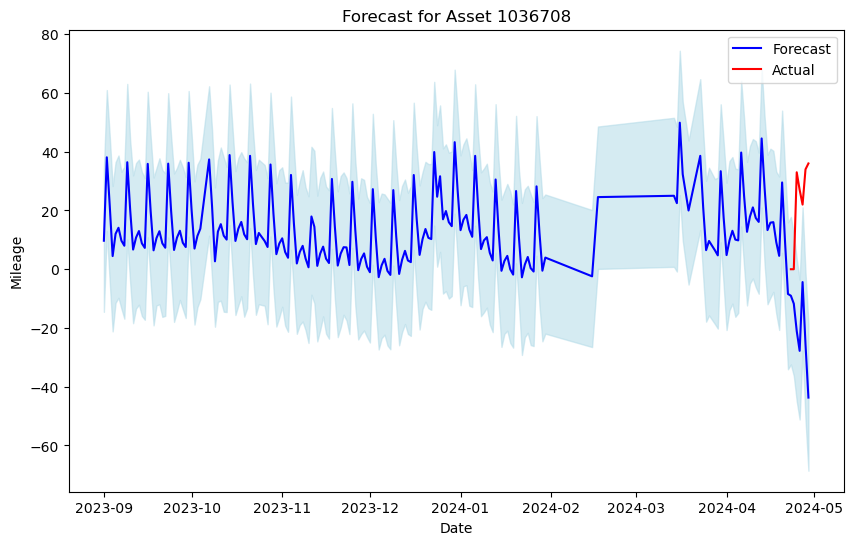

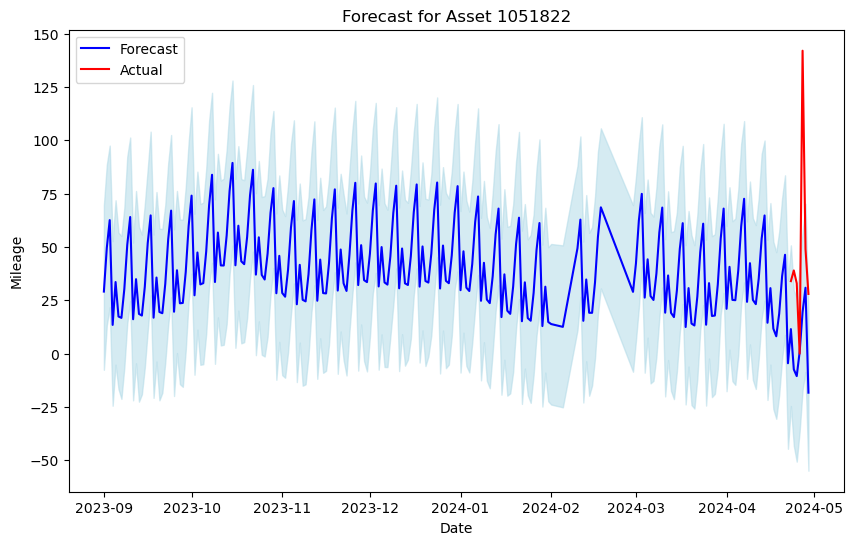

In [8]:
# Plot the forecast for each asset with confidence intervals
for asset_id, group in final_forecast.groupby('Asset_ID'):
    plt.figure(figsize=(10, 6))
    plt.title(f'Forecast for Asset {asset_id}')
    plt.plot(group['ds'], group['yhat'], label='Forecast', color='blue')
    plt.fill_between(group['ds'], group['yhat_lower'], group['yhat_upper'], color='lightblue', alpha=0.5)
    
    # Plot the actual test data
    test_group = test_data[test_data['Asset_ID'] == asset_id].rename(columns={'Date': 'ds', 'Daily_mileage': 'y'})
    plt.plot(test_group['ds'], test_group['y'], label='Actual', color='red')
    
    plt.xlabel('Date')
    plt.ylabel('Mileage')
    plt.legend()
    plt.show()


21:06:13 - cmdstanpy - INFO - Chain [1] start processing
21:06:13 - cmdstanpy - INFO - Chain [1] done processing


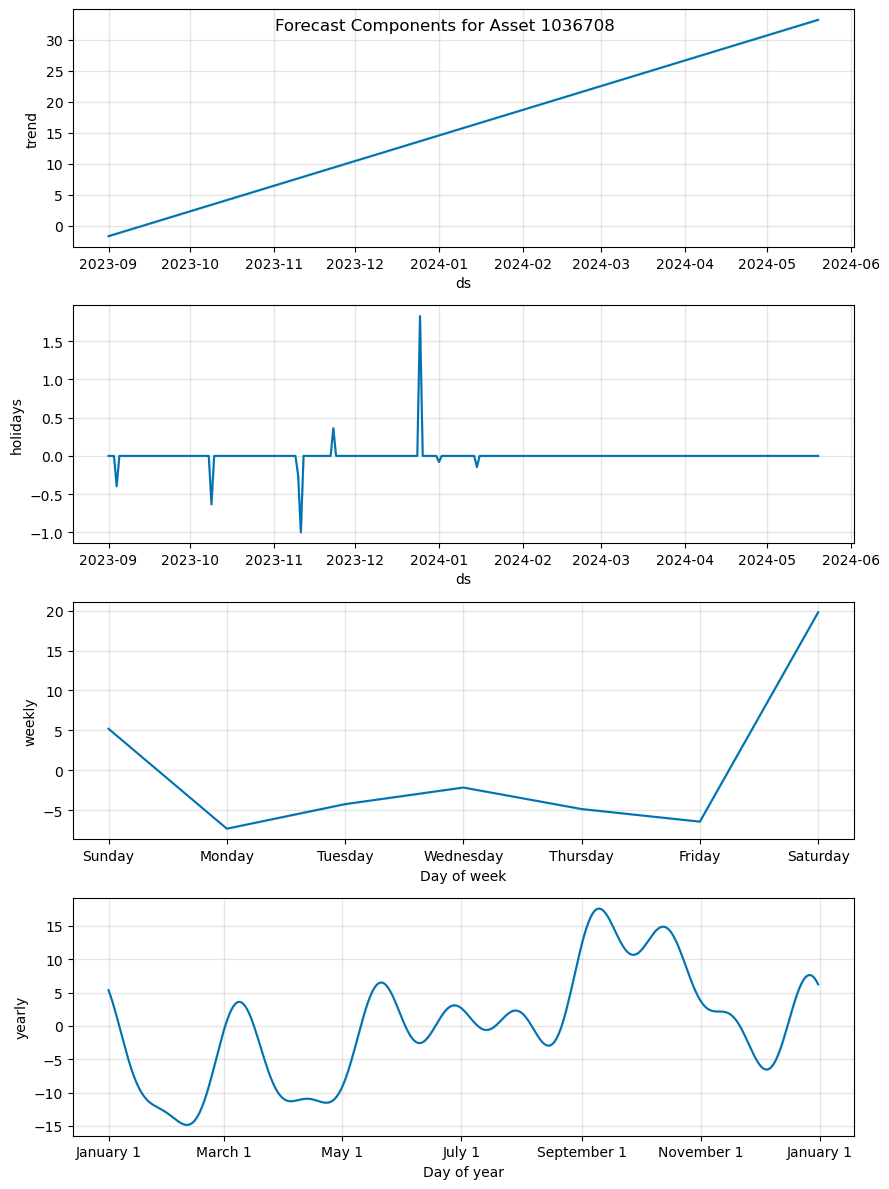

21:06:14 - cmdstanpy - INFO - Chain [1] start processing
21:06:14 - cmdstanpy - INFO - Chain [1] done processing


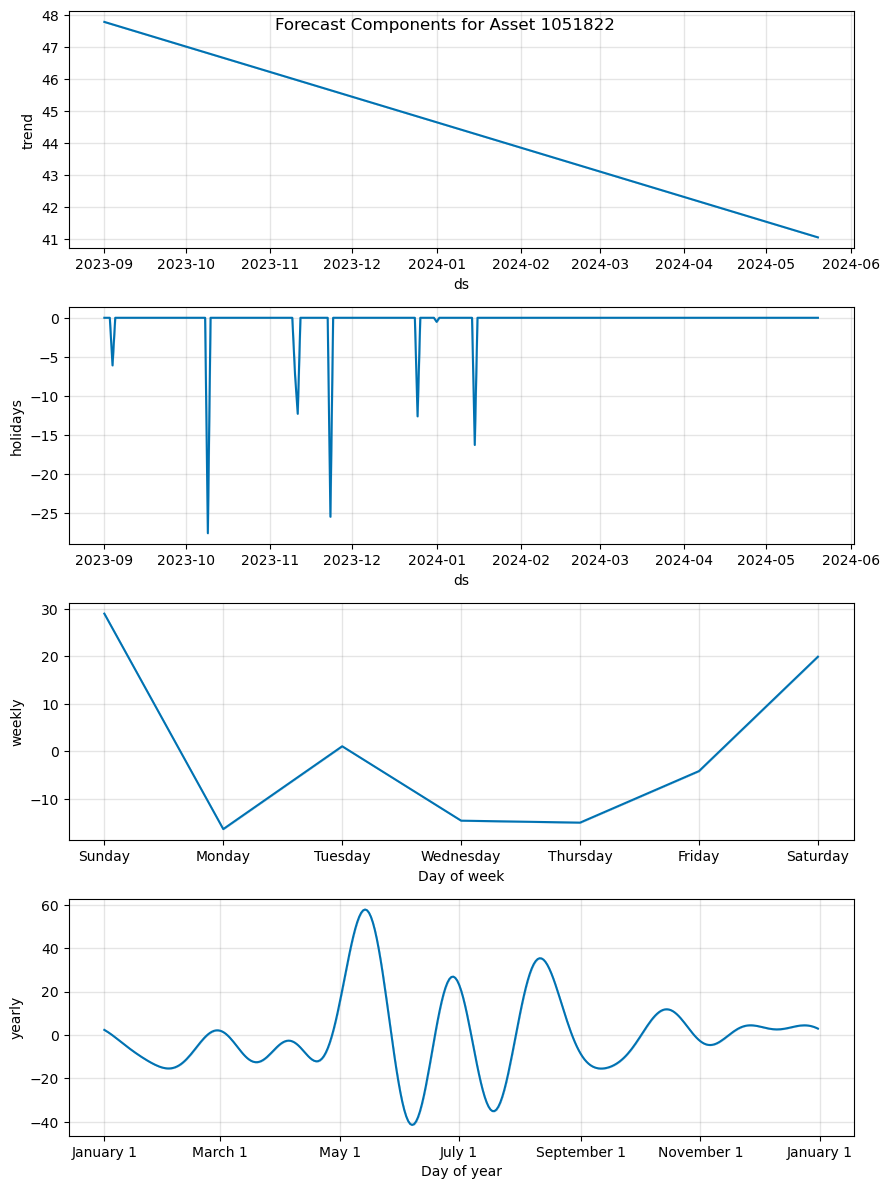

In [9]:
# Decompose the forecast components for each asset
for asset_id, group in df.groupby('Asset_ID'):
    # Prepare the data for Prophet
    group = group.rename(columns={'Date': 'ds', 'Daily_mileage': 'y'})
    
    # Initialize the Prophet model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    
    # Add holidays
    model.add_country_holidays(country_name='US')
    
    # Fit the model
    model.fit(group)
    
    # Plot components
    model.plot_components(model.predict(model.make_future_dataframe(periods=21)))
    plt.suptitle(f'Forecast Components for Asset {asset_id}')
    plt.show()